###                                Predicting upgrade customers from Pass One Fans

#### Pass One Fans are fans that purchase tickets for a specific event this excludes Season Ticket Holders, Partial Season Ticket Holders and Mini-Season Pass Holders

#### This model is more than likely not going to be a highly predictive model.  There is  limited data available about the customer and the data used in this model contains only transactional data.  

#### The purpose of this notebook is to show the use of Artificial Neural Network techniques used to predict the purchase of an upgrade by  fans that purchased pass one tickets.  Only fans of 7 NBA teams were used as a datsource due to the scarcity of upgrade ticketing data across the 15+ teams available in the database

### The NBA Team Names were anonymized  to protect their Privacy

### Connections to Databases and importing packages 

#### Initially the data was queried using SQL from a Redshift Database and produced a dataframe called "passone".  I exported the passone dataframe as a csv to be reimported into Jupyter Notebook on a local machine to complete this analysis. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import psycopg2
import sys
from sqlalchemy import create_engine
import os
import subprocess
import datetime as dt
import requests
import lxml.html as lh
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV   
from sklearn.preprocessing import StandardScaler
# from pathlib import Path 
# from dotenv import load_dotenv, find_dotenv
# load_dotenv(find_dotenv())
# # env_path = './.env'
# env_path =  Path('/home/ec2-user/')
# #load_dotenv(dotenv_path=env_path)
# postgres_user = os.environ['PSQL_USERNAME']
# postgres_pw = os.environ['PSQL_PASSWORD']
# postgres_url = os.environ['PSQL_URL']
# redshift_user = os.environ['REDSHIFT_USERNAME']
# redshift_pw = os.environ['REDSHIFT_PASSWORD']
# redshift_url = os.environ['REDSHIFT_URL']

# if don't have package imbalanced run below line 
#! pip install imbalanced-learn


#### This block makes the connection to postgres db (tableau/follower)

In [2]:
# #this block makes the connection to postgres db (tableau/follower)
# conn_string = "host='"+postgres_url+"' dbname='experience' user='"+postgres_user+"' password='"+postgres_pw+"'"
# conn = psycopg2.connect(conn_string)
# cursor = conn.cursor()

#### This block makes the connection to redshift (redluma)

In [3]:
# #this block makes the connection to redshift (redluma)
# red_engine = create_engine('postgresql://'+redshift_user+':'+redshift_pw+'@'+redshift_url)
# conn_red = red_engine.raw_connection()
# cur = conn_red.cursor()

#### Connecting to Redshift Databases using sql

#### Pulling NBA fan transactions for pass one fans and if they upgraded or not

In [4]:
# sql_statement="""


# with upgraders as(
# select distinct segment,group_id as team_id,product_key,product,
#                 case when product_key=0 then 1 end as upgrade_fan,
#                 case when group_id in(1047) then 'Team 1'
#                 when group_id in(14) then 'Team 2'
#                 when group_id in(1082) then 'Team 3'
#                 when group_id in(8) then 'Team 4'
#                 when group_id in (4) then 'Team 5'
#                 when group_id in(983) then 'Team 6'
#                 when group_id in(7) then 'Team 7' end as Team,
#                 count(distinct upgrade_id) as num_upgrades,sum(group_size) as upgrade_tickets,
#                 sum(gross_sales) as upgrade_gross,sum(net_sales) as upgrade_net
# from mart.all_transactions at
# join mart.season s on at.group_type_id=s.group_type_id and at.event_date between s.start_date and s.end_date
# where product_key in(0) and group_id in(1047,14,1082,8,4,983,7)
# and active_filter=1 and expapp_email_flag=0 and s.season_name in('2017-2018','2018-2019','2019-2020')
# and at.event_date<='2020-03-15' --Games Cancelled after this due to Covid
# group by 1,2,3,4,5
# having sum(gross_sales)>0),

# --Creating a temp table containing all fans that purchased pass one tickets 
# passone as(
#     select segment,group_id as team_id,product_key,product,
#            sum(gross_sales) as p1_gross,sum(net_sales) as p1_net,
#            sum(gross_sales)/count(distinct event_id) as avg_gross_spend_per_event,
#            sum(net_sales)/count(distinct event_id) as avg_net_spend_per_event,
#                 sum(total_discounted_amount) as p1_discounts,
#            count(distinct event_id) as num_p1_events,
#            count(distinct upgrade_id) as pass_one_transactions,
#            sum(group_size) as p1_tickets,
#            count(distinct season_name) as num_p1_seasons
#     from mart.all_transactions at2
#     join mart.season s on at2.group_type_id=s.group_type_id and at2.event_date between s.start_date and s.end_date
#     where product_key in(12) and group_id in(1047,14,1082,8,4,983,7)
#       and active_filter=1 and expapp_email_flag=0 and s.season_name in('2017-2018','2018-2019','2019-2020')
#       and at2.event_date<='2020-03-15' --Games Cancelled after this due to Covid
#     group by 1,2,3,4,5
#     having sum(net_sales)>0
# )

# select p1.*,coalesce(u.upgrade_fan,0)as upgrade_fan,num_upgrades,upgrade_tickets,
#        upgrade_gross,upgrade_net
# from passone p1
# left join upgraders u on p1.team_id=u.team_id and p1.fan_id=u.fan_id




# ;
# """
# passone = pd.read_sql(sql_statement, conn_red) 

### Exporting data to CSV

#### This was done to allow for utilization of passone data on local machine. Not all packages were available on the Remote Desktop version of Jupyter Notebook. Such as imblearn packages.

In [5]:
# passone.to_csv(r'pass_one.csv', index = False)

### Importing passone csv to local copy of Jupyter Notebook

In [6]:
passone = pd.read_csv("/Users/gregsaunders/Documents/pass_one.csv")

In [7]:
# Checking data
passone.head()

,segment,team_id,product_key,product,team,p1_gross,p1_net,avg_gross_spend_per_event,avg_net_spend_per_event,p1_discounts,num_p1_events,pass_one_transactions,p1_tickets,num_p1_seasons,upgrade_fan,num_upgrades,upgrade_tickets,upgrade_gross,upgrade_net
0,NBA,4,12,Pass One,Team 5,94,94.0,18.800000,18.800000,0.0,5,5,10,2,0,NaN,NaN,NaN,NaN
1,NBA,4,12,Pass One,Team 5,104,104.0,20.800000,20.800000,0.0,5,5,10,2,0,NaN,NaN,NaN,NaN
2,NBA,4,12,Pass One,Team 5,258,258.0,23.454545,23.454545,0.0,11,11,22,2,1,2.0,3.0,38.17,38.17
3,NBA,4,12,Pass One,Team 5,50,50.0,25.000000,25.000000,0.0,2,2,4,1,0,NaN,NaN,NaN,NaN
4,NBA,4,12,Pass One,Team 5,90,90.0,22.500000,22.500000,0.0,4,4,10,3,1,1.0,4.0,89.84,89.84


#### Dataframe produced with 31,849 observations of pass one fans and 3555 of these fans upgraded

In [8]:
passone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31849 entries, 0 to 31848
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   segment                    31849 non-null  object 
 1   team_id                    31849 non-null  int64  
 2   product_key                31849 non-null  int64  
 3   product                    31849 non-null  object 
 4   team                       31849 non-null  object 
 5   p1_gross                   31849 non-null  int64  
 6   p1_net                     31849 non-null  float64
 7   avg_gross_spend_per_event  31849 non-null  float64
 8   avg_net_spend_per_event    31849 non-null  float64
 9   p1_discounts               31849 non-null  float64
 10  num_p1_events              31849 non-null  int64  
 11  pass_one_transactions      31849 non-null  int64  
 12  p1_tickets                 31849 non-null  int64  
 13  num_p1_seasons             31849 non-null  int

##                                  Exploratory Data Analysis

### Count Plot distribution shows the target class ( upgraded_fan) is a bit unbalanced which may make it difficult to predict upgrading of Pass One Fans, will try to correct for this later in Notebook

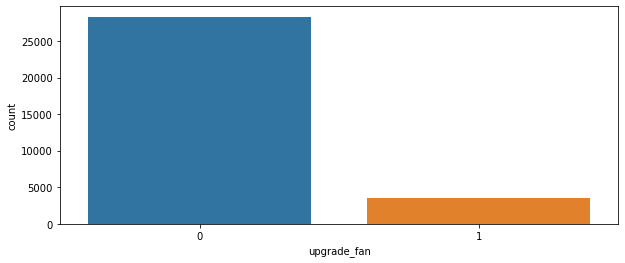

In [9]:
# Distribution of upgrades vs. no upgrades
plt.figure(figsize = (10,4))
sns.countplot(x='upgrade_fan',data=passone)
plt.show()

In [10]:
# Looking at the % of upgrading fans in the dataframe compared to the non-upgraders
noupgrading = len(passone[passone['upgrade_fan']==0])
upgrading = len(passone[passone['upgrade_fan']==1])
pct_of_no_upgrading = noupgrading/(upgrading+noupgrading)
print("percentage of fans that did not upgrade is", pct_of_no_upgrading*100)
pct_of_upgrading = upgrading/(upgrading+noupgrading)
print("percentage of pass one fans that upgraded", pct_of_upgrading*100)

percentage of fans that did not upgrade is 88.83795409588998
percentage of pass one fans that upgraded 11.16204590411002


## Exploring Pass One Fan features

### It appears that those fans that upgraded spent more on pass one tickets and attended more events and subsequently purchased more tickets, however there doesn't seen to be much difference between the 2 classes on the tenure of seasons a fan purchased a pass one ticket

In [11]:
groupby_features = passone[['upgrade_fan','p1_gross','p1_net','num_p1_events','p1_tickets','pass_one_transactions','num_p1_seasons']]
groupby_features.groupby('upgrade_fan').mean()

,p1_gross,p1_net,num_p1_events,p1_tickets,pass_one_transactions,num_p1_seasons
upgrade_fan,,,,,,
0,75.650880,75.562345,1.834841,4.739167,1.840779,1.167774
1,120.138959,119.703494,3.214627,7.463291,3.220534,1.384810


### Some teams don't have lots of upgraded fans that use pass one like Teams 4 and 7

In [12]:
p_groupby_features = passone[['team_id','upgrade_fan']]
total_fans = p_groupby_features.groupby('team_id').count()
upgrade_fans = p_groupby_features.groupby('team_id').sum()
summary = upgrade_fans/total_fans * 100
print( " # Fans that purchased Pass One Tickets", total_fans)
print (" ")
print (" # of Pass One Fans that purchased upgrades ", upgrade_fans)
print (" ")
print (" % of Pass One Fans that purchased Upgrades", summary)

 # Fans that purchased Pass One Tickets          upgrade_fan
team_id             
4              10608
7               7725
8               7094
14              4156
983              422
1047            1219
1082             625
 
 # of Pass One Fans that purchased upgrades           upgrade_fan
team_id             
4                813
7                766
8               1216
14               402
983               72
1047             181
1082             105
 
 % of Pass One Fans that purchased Upgrades          upgrade_fan
team_id             
4           7.664027
7           9.915858
8          17.141246
14          9.672762
983        17.061611
1047       14.848236
1082       16.800000


## Distributions of the Features

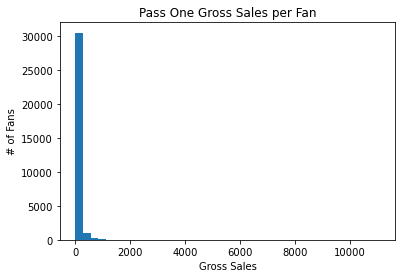

In [13]:

passone['p1_gross'].plot.hist(bins=40)
plt.title('Pass One Gross Sales per Fan')
plt.xlabel('Gross Sales')
plt.ylabel('# of Fans')
plt.show()

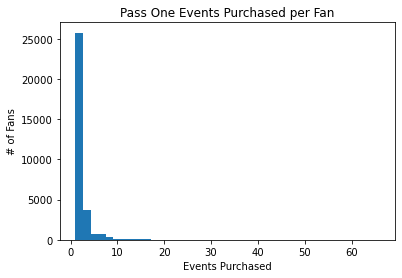

In [14]:
## Distribution of pass one events purchased
passone['num_p1_events'].plot.hist(bins=40)
plt.title('Pass One Events Purchased per Fan')
plt.xlabel('Events Purchased')
plt.ylabel('# of Fans')
plt.show()

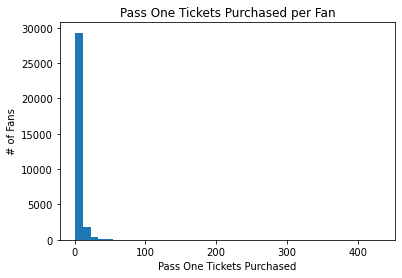

In [15]:
## Distribution of pass one tickets purchased
passone['p1_tickets'].plot.hist(bins=40)
plt.title('Pass One Tickets Purchased per Fan')
plt.xlabel('Pass One Tickets Purchased')
plt.ylabel('# of Fans')
plt.show()

### Something off about the distributions as seen above checking the descriptive statistics for the dataframe below notice that the Avg gross sales is about 80 dollars and the median is around 40 dollars indicating a large skewness of the data due to outliers. The 75th percentile falls at around 90 dollars with a max of 11k.  The others are distorted by extreme values in the data

In [16]:
metrics = passone[['p1_gross','p1_net','avg_gross_spend_per_event','avg_net_spend_per_event','num_p1_events','pass_one_transactions','p1_tickets','num_p1_seasons']]

metrics.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p1_gross,31849.0,80.616660,166.429491,1.0,20.0,40.0,90.0,11069.0
p1_net,31849.0,80.489401,166.307914,1.0,20.0,40.0,90.0,11069.0
avg_gross_spend_per_event,31849.0,39.239916,36.004091,1.0,20.0,30.0,45.0,660.0
avg_net_spend_per_event,31849.0,39.198316,36.009715,1.0,20.0,30.0,45.0,660.0
num_p1_events,31849.0,1.988854,2.323005,1.0,1.0,1.0,2.0,66.0
pass_one_transactions,31849.0,1.994788,2.365054,1.0,1.0,1.0,2.0,76.0
p1_tickets,31849.0,5.043235,7.790262,1.0,2.0,3.0,6.0,431.0
num_p1_seasons,31849.0,1.192000,0.449361,1.0,1.0,1.0,1.0,3.0


### Checking number of observations that are above certain thresholds to determine if we can exclude these outliers

In [17]:
### Some extreme outliers in pass one gross sales need to examine further
above400 = passone[(passone['p1_gross'] >400) & (passone['upgrade_fan']>0)]
print("# of upgraders that spend more than 400 dollars", len(above400))
above600 = passone[(passone['p1_gross'] >600) & (passone['upgrade_fan']>0) ] 
print("# of upgraders that spend more than 600 dollars", len(above600))# 58 obs with upgrades
above1000 = passone[(passone['p1_gross'] >1000) & (passone['upgrade_fan']>0) ] # 18 obs with upgrades
print("# of upgraders that spend more than 1000 dollars", len(above1000))
above1300 = passone[(passone['p1_gross'] >1300) & (passone['upgrade_fan']>0) ] # 7 obs with upgrades
print("# of upgraders that spend more than 1300 dollars", len(above1300))
above1600 = passone[(passone['p1_gross'] >1600) & (passone['upgrade_fan']>0) ] # 4 obs with upgrades
print("# of upgraders that spend more than 1600 dollars", len(above1600))
print(len(above400) + len(above600) + len(above1000) + len(above1300) +len(above1600))

# of upgraders that spend more than 400 dollars 162
# of upgraders that spend more than 600 dollars 58
# of upgraders that spend more than 1000 dollars 18
# of upgraders that spend more than 1300 dollars 7
# of upgraders that spend more than 1600 dollars 4
249


### It appears most high spenders that purchase pass one tickets don't upgrade often.  The high spending pass one fans may not be individual fans but a fan purchasing bulk tickets for a company, etc.

## Outliers in the data need to be dealt with 

Text(0, 0.5, '# of Fans')

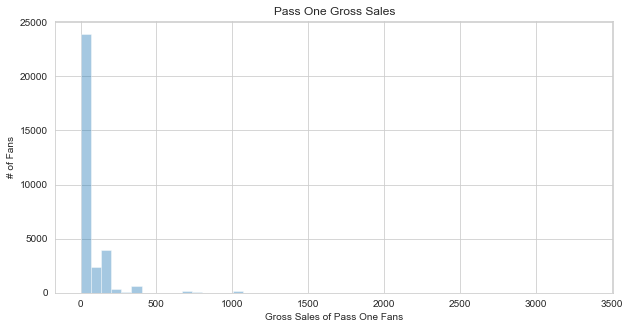

In [18]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
sns.distplot(passone["p1_gross"][passone['p1_gross'] ],kde=False, bins =50)
plt.title('Pass One Gross Sales')
plt.xlabel('Gross Sales of Pass One Fans')
plt.ylabel('# of Fans')

Text(0, 0.5, '# of Fans')

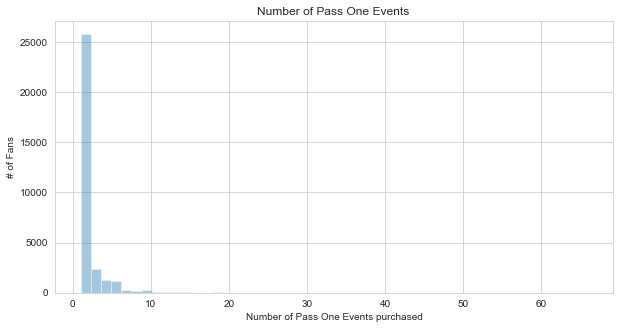

In [19]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
sns.distplot(passone["num_p1_events"],kde=False, bins =50)
plt.title('Number of Pass One Events ')
plt.xlabel('Number of Pass One Events purchased')
plt.ylabel('# of Fans')

Text(0, 0.5, '# of Fans')

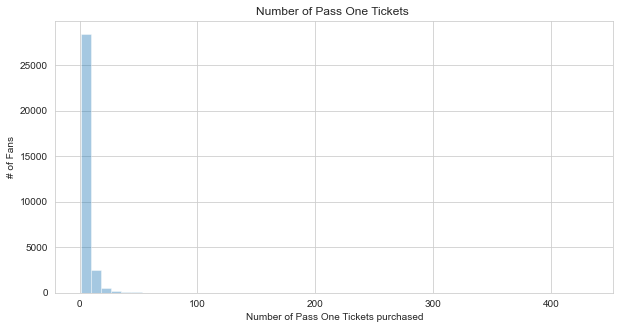

In [20]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
sns.distplot(passone["p1_tickets"],kde=False, bins =50)
plt.title('Number of Pass One Tickets ')
plt.xlabel('Number of Pass One Tickets purchased')
plt.ylabel('# of Fans')

### Standardizing the features below using Z-scores then eliminating Outliers by using Z-Score <3 

In [21]:
### Going to transform using z-score

import scipy

In [22]:
zscore = passone[['p1_gross','num_p1_events','p1_tickets']]

In [23]:
zscore = scipy.stats.zscore(zscore)

In [24]:
abs_z_scores = np.abs(zscore)

In [25]:
abs_z_scores
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = passone[filtered_entries]


### The new dataframe went from n=31,849 obs to 30,980 obs after removing outliers

In [26]:

new_df.head()

,segment,team_id,product_key,product,team,p1_gross,p1_net,avg_gross_spend_per_event,avg_net_spend_per_event,p1_discounts,num_p1_events,pass_one_transactions,p1_tickets,num_p1_seasons,upgrade_fan,num_upgrades,upgrade_tickets,upgrade_gross,upgrade_net
0,NBA,4,12,Pass One,Team 5,94,94.0,18.8,18.8,0.0,5,5,10,2,0,NaN,NaN,NaN,NaN
1,NBA,4,12,Pass One,Team 5,104,104.0,20.8,20.8,0.0,5,5,10,2,0,NaN,NaN,NaN,NaN
3,NBA,4,12,Pass One,Team 5,50,50.0,25.0,25.0,0.0,2,2,4,1,0,NaN,NaN,NaN,NaN
4,NBA,4,12,Pass One,Team 5,90,90.0,22.5,22.5,0.0,4,4,10,3,1,1.0,4.0,89.84,89.84
5,NBA,4,12,Pass One,Team 5,60,60.0,20.0,20.0,0.0,3,3,7,1,0,NaN,NaN,NaN,NaN


## Distributions after outliers removed from dataframe

Text(0, 0.5, '# of Fans')

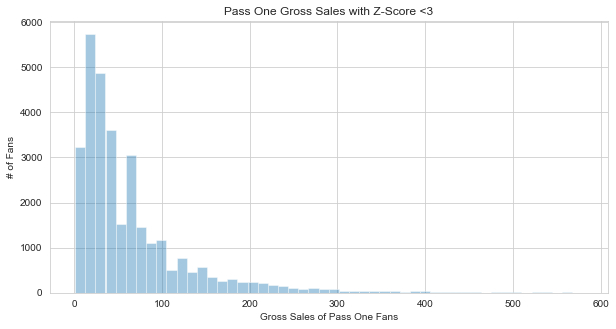

In [27]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
sns.distplot(new_df["p1_gross"],kde=False, bins =50)
plt.title('Pass One Gross Sales with Z-Score <3')
plt.xlabel('Gross Sales of Pass One Fans')
plt.ylabel('# of Fans')

Text(0, 0.5, '# of Fans')

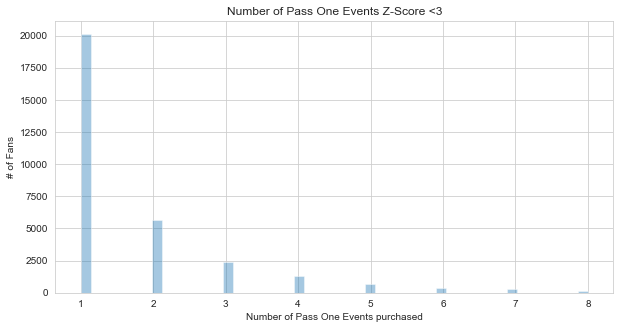

In [28]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
sns.distplot(new_df["num_p1_events"],kde=False, bins =50)
plt.title('Number of Pass One Events Z-Score <3')
plt.xlabel('Number of Pass One Events purchased')
plt.ylabel('# of Fans')

Text(0, 0.5, '# of Fans')

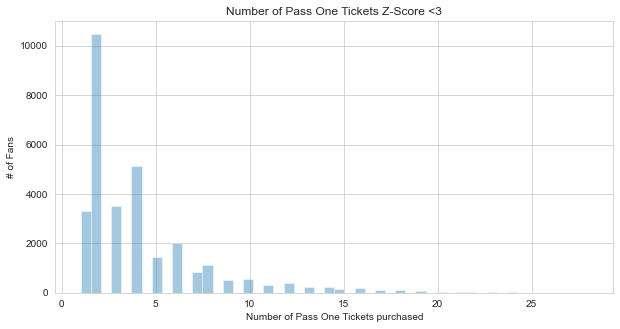

In [29]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
sns.distplot(new_df["p1_tickets"],kde=False, bins =50)
plt.title('Number of Pass One Tickets Z-Score <3')
plt.xlabel('Number of Pass One Tickets purchased')
plt.ylabel('# of Fans')

### Features Review

In [30]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30980 entries, 0 to 31848
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   segment                    30980 non-null  object 
 1   team_id                    30980 non-null  int64  
 2   product_key                30980 non-null  int64  
 3   product                    30980 non-null  object 
 4   team                       30980 non-null  object 
 5   p1_gross                   30980 non-null  int64  
 6   p1_net                     30980 non-null  float64
 7   avg_gross_spend_per_event  30980 non-null  float64
 8   avg_net_spend_per_event    30980 non-null  float64
 9   p1_discounts               30980 non-null  float64
 10  num_p1_events              30980 non-null  int64  
 11  pass_one_transactions      30980 non-null  int64  
 12  p1_tickets                 30980 non-null  int64  
 13  num_p1_seasons             30980 non-null  int

In [31]:
df= new_df[['team','p1_gross','p1_net','avg_gross_spend_per_event','avg_net_spend_per_event','num_p1_events','pass_one_transactions','p1_tickets','num_p1_seasons','upgrade_fan']]

### Dataframe with removed outliers called df

### Checking correlations of Features with target

In [32]:
df.drop(['upgrade_fan','team'], axis=1).apply(lambda x: x.corr(df.upgrade_fan)).sort_values( ascending=False)

num_p1_events                0.204776
pass_one_transactions        0.204614
p1_tickets                   0.144694
p1_gross                     0.131031
p1_net                       0.130410
num_p1_seasons               0.126876
avg_gross_spend_per_event   -0.006951
avg_net_spend_per_event     -0.007413
dtype: float64

In [33]:
df.head()

,team,p1_gross,p1_net,avg_gross_spend_per_event,avg_net_spend_per_event,num_p1_events,pass_one_transactions,p1_tickets,num_p1_seasons,upgrade_fan
0,Team 5,94,94.0,18.8,18.8,5,5,10,2,0
1,Team 5,104,104.0,20.8,20.8,5,5,10,2,0
3,Team 5,50,50.0,25.0,25.0,2,2,4,1,0
4,Team 5,90,90.0,22.5,22.5,4,4,10,3,1
5,Team 5,60,60.0,20.0,20.0,3,3,7,1,0


### Creating dummy variables to identify different Teams

#### Will remove pass_one_transactions, p1_net,avg_gross_spend_per_event, avg_net_spend_per_event due to prevent multicolinearity and due to weak correlation values

In [34]:
modeling_data = new_df[['team','num_p1_events','num_p1_seasons','p1_gross','p1_tickets','upgrade_fan']]

In [35]:
cat_vars =['team']
for var in cat_vars:
    cat_list=var
    cat_list = pd.get_dummies(modeling_data[var])
    modeling_data1=modeling_data.join(cat_list)
    modeling_data=modeling_data1

cat_vars = ['team']
data_vars = modeling_data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
    

In [36]:
modeling_data = modeling_data.drop(('team'), axis=1)
modeling_data

,num_p1_events,num_p1_seasons,p1_gross,p1_tickets,upgrade_fan,Team 1,Team 2,Team 3,Team 4,Team 5,Team 6,Team 7
0,5,2,94,10,0,0,0,0,0,1,0,0
1,5,2,104,10,0,0,0,0,0,1,0,0
3,2,1,50,4,0,0,0,0,0,1,0,0
4,4,3,90,10,1,0,0,0,0,1,0,0
5,3,1,60,7,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
31844,1,1,10,1,0,0,0,0,0,1,0,0
31845,1,1,102,3,0,0,0,0,0,0,1,0
31846,1,1,80,2,0,0,0,1,0,0,0,0
31847,1,1,20,2,1,0,0,0,1,0,0,0


In [37]:
modeling_data.head()

,num_p1_events,num_p1_seasons,p1_gross,p1_tickets,upgrade_fan,Team 1,Team 2,Team 3,Team 4,Team 5,Team 6,Team 7
0,5,2,94,10,0,0,0,0,0,1,0,0
1,5,2,104,10,0,0,0,0,0,1,0,0
3,2,1,50,4,0,0,0,0,0,1,0,0
4,4,3,90,10,1,0,0,0,0,1,0,0
5,3,1,60,7,0,0,0,0,0,1,0,0


In [38]:
noupgrading = len(modeling_data[modeling_data['upgrade_fan']==0])
upgrading = len(modeling_data[modeling_data['upgrade_fan']==1])
pct_of_no_upgrading = noupgrading/(upgrading+noupgrading)
print("percentage of no upgrading is", pct_of_no_upgrading*100)
pct_of_upgrading = upgrading/(upgrading+noupgrading)
print("percentage of upgrading", pct_of_upgrading*100)

percentage of no upgrading is 89.34796642995481
percentage of upgrading 10.65203357004519


### Correlation Plot of Feature Variables

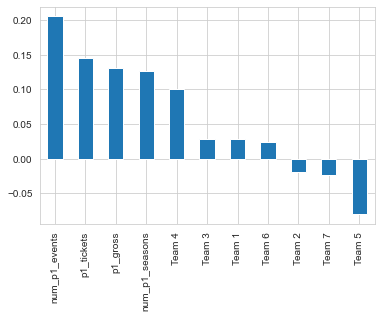

In [39]:
modeling_data.drop(['upgrade_fan'], axis=1).apply(lambda x: x.corr(modeling_data.upgrade_fan)).sort_values( ascending=False).plot(kind='bar')


## Trying Neural Network Modeling

In [40]:
X= modeling_data[['num_p1_events','num_p1_seasons','p1_gross','p1_tickets','Team 1','Team 2','Team 3','Team 4','Team 5','Team 6','Team 7']].values
y =modeling_data['upgrade_fan'].values

## Undersampling data to help correct for unbalanced target class upgrade_fan

Neighborhood Cleaning Rule for Undersampling
The Neighborhood Cleaning Rule, or NCR for short, is an undersampling technique that combines both the Condensed Nearest Neighbor (CNN) Rule to remove redundant examples and the Edited Nearest Neighbors (ENN) Rule to remove noisy or ambiguous examples.

In [41]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import NeighbourhoodCleaningRule
from matplotlib import pyplot
from numpy import where

# summarize class distribution
counter = Counter(y)
print(counter)
# define the undersampling method
undersample = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
# transform the dataset
X, y = undersample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
# for label, _ in counter.items():
# 	row_ix = where(y == label)[0]
# 	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
# pyplot.legend()
# pyplot.show()

Counter({0: 27680, 1: 3300})
Counter({0: 23544, 1: 3300})


In [42]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=59)


### Scaling the Data 

In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [44]:
scaler.fit(X_train)

MinMaxScaler()

In [45]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Building Neural Network Model on Training  using Keras data

In [46]:
from tensorflow.keras import Sequential

In [47]:
from tensorflow.keras.layers import Dense,Dropout

In [48]:
X_train.shape

(20133, 11)

## Model 1 with an arbitrarly chosen Epoch n=200

In [49]:
model_1 = Sequential()

model_1.add(Dense(11, activation='relu'))

model_1.add(Dense(5, activation='relu'))

# Binary Classification
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy',optimizer='adam')

In [50]:
model_1.fit(x=X_train,y=y_train,epochs=200,validation_data=(X_test,y_test))

Epoch 1/200
630/630 [==============================] - 0s 743us/step - loss: 0.3684 - val_loss: 0.3410
Epoch 2/200
630/630 [==============================] - 0s 573us/step - loss: 0.3290 - val_loss: 0.3365
Epoch 3/200
630/630 [==============================] - 0s 569us/step - loss: 0.3269 - val_loss: 0.3351
Epoch 4/200
630/630 [==============================] - 0s 584us/step - loss: 0.3257 - val_loss: 0.3334
Epoch 5/200
630/630 [==============================] - 0s 580us/step - loss: 0.3247 - val_loss: 0.3327
Epoch 6/200
630/630 [==============================] - 0s 577us/step - loss: 0.3240 - val_loss: 0.3315
Epoch 7/200
630/630 [==============================] - 0s 573us/step - loss: 0.3234 - val_loss: 0.3312
Epoch 8/200
630/630 [==============================] - 0s 582us/step - loss: 0.3230 - val_loss: 0.3307
Epoch 9/200
630/630 [==============================] - 0s 575us/step - loss: 0.3227 - val_loss: 0.3299
Epoch 10/200
630/630 [==============================] - 0s 583us/step - l

Epoch 80/200
630/630 [==============================] - 0s 568us/step - loss: 0.3176 - val_loss: 0.3260
Epoch 81/200
630/630 [==============================] - 0s 562us/step - loss: 0.3176 - val_loss: 0.3259
Epoch 82/200
630/630 [==============================] - 0s 554us/step - loss: 0.3176 - val_loss: 0.3265
Epoch 83/200
630/630 [==============================] - 0s 560us/step - loss: 0.3179 - val_loss: 0.3259
Epoch 84/200
630/630 [==============================] - 0s 561us/step - loss: 0.3174 - val_loss: 0.3262
Epoch 85/200
630/630 [==============================] - 0s 563us/step - loss: 0.3176 - val_loss: 0.3258
Epoch 86/200
630/630 [==============================] - 0s 563us/step - loss: 0.3177 - val_loss: 0.3263
Epoch 87/200
630/630 [==============================] - 0s 567us/step - loss: 0.3178 - val_loss: 0.3258
Epoch 88/200
630/630 [==============================] - 0s 568us/step - loss: 0.3175 - val_loss: 0.3267
Epoch 89/200
630/630 [==============================] - 0s 564us

630/630 [==============================] - 0s 603us/step - loss: 0.3168 - val_loss: 0.3259
Epoch 159/200
630/630 [==============================] - 0s 592us/step - loss: 0.3170 - val_loss: 0.3260
Epoch 160/200
630/630 [==============================] - 0s 566us/step - loss: 0.3171 - val_loss: 0.3257
Epoch 161/200
630/630 [==============================] - 0s 569us/step - loss: 0.3168 - val_loss: 0.3262
Epoch 162/200
630/630 [==============================] - 0s 605us/step - loss: 0.3169 - val_loss: 0.3256
Epoch 163/200
630/630 [==============================] - 0s 575us/step - loss: 0.3169 - val_loss: 0.3276
Epoch 164/200
630/630 [==============================] - 0s 586us/step - loss: 0.3169 - val_loss: 0.3263
Epoch 165/200
630/630 [==============================] - 0s 585us/step - loss: 0.3168 - val_loss: 0.3264
Epoch 166/200
630/630 [==============================] - 0s 590us/step - loss: 0.3168 - val_loss: 0.3262
Epoch 167/200
630/630 [==============================] - 0s 590us/ste

### Checking loss from model history

#### This model is Overfit as the loss increases with further epochs

In [51]:
#plot out loss
model_1_losses = pd.DataFrame(model_1.history.history)


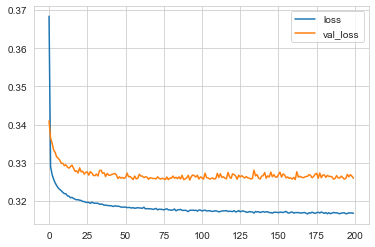

In [52]:
model_1_losses.plot()
plt.show()

##  Passing X_test into model to get predictions from Model 1

In [53]:

predictions = model_1.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [54]:
from sklearn.metrics import classification_report, confusion_matrix

In [55]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      5858
           1       0.68      0.14      0.24       853

    accuracy                           0.88      6711
   macro avg       0.78      0.57      0.59      6711
weighted avg       0.86      0.88      0.85      6711



In [56]:
print(confusion_matrix(y_test,predictions))

[[5799   59]
 [ 730  123]]


### Performed slightly better than the  logistic regression model

#### This model correctly classified 5799 Non-Upgrade fans out of the 5858 Non-Upgrade Fans (True +) and correctly classified 123 out of the 853 upgrade fans (True -) for an accuracy of 88% <br>
#### The False + rate is quite high with 730 upgraders classified as Non-Upgrade Fans and<br>
#### 59 Non-Upgrade Fans were classified as Upgrade Fans (False -)

## Model 2 Using Early Stopping instead of choosing an arbitrarly chosen epoch

In [57]:
### creating new model

model_2 = Sequential()

model_2.add(Dense(11, activation='relu'))

model_2.add(Dense(5, activation='relu'))

# Binary Classification
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(loss='binary_crossentropy',optimizer='adam')

In [58]:
from tensorflow.keras.callbacks import EarlyStopping

In [59]:
#Create a early stop variable that will be added as a parameter to model.fit
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)

In [60]:
model_2.fit(x=X_train,y=y_train,epochs=200,validation_data=(X_test,y_test),callbacks=[early_stop])

Epoch 1/200
630/630 [==============================] - 0s 645us/step - loss: 0.3996 - val_loss: 0.3441
Epoch 2/200
630/630 [==============================] - 0s 570us/step - loss: 0.3305 - val_loss: 0.3362
Epoch 3/200
630/630 [==============================] - 0s 577us/step - loss: 0.3270 - val_loss: 0.3334
Epoch 4/200
630/630 [==============================] - 0s 567us/step - loss: 0.3255 - val_loss: 0.3315
Epoch 5/200
630/630 [==============================] - 0s 573us/step - loss: 0.3242 - val_loss: 0.3302
Epoch 6/200
630/630 [==============================] - 0s 565us/step - loss: 0.3234 - val_loss: 0.3299
Epoch 7/200
630/630 [==============================] - 0s 572us/step - loss: 0.3228 - val_loss: 0.3283
Epoch 8/200
630/630 [==============================] - 0s 571us/step - loss: 0.3219 - val_loss: 0.3278
Epoch 9/200
630/630 [==============================] - 0s 573us/step - loss: 0.3217 - val_loss: 0.3283
Epoch 10/200
630/630 [==============================] - 0s 575us/step - l

## Early Stopping -to track the val_loss and stop training once it begins increasing too much!

Arguments:
    monitor: Quantity to be monitored.<br>
    min_delta: Minimum change in the monitored quantity
        to qualify as an improvement, i.e. an absolute
        change of less than min_delta, will count as no
        improvement.<br>
    patience: Number of epochs with no improvement
        after which training will be stopped. <br>
    verbose: verbosity mode.
    mode: One of `{"auto", "min", "max"}`. In `min` mode,
        training will stop when the quantity
        monitored has stopped decreasing; in `max`
        mode it will stop when the quantity
        monitored has stopped increasing; in `auto`
        mode, the direction is automatically inferred
        from the name of the monitored quantity.

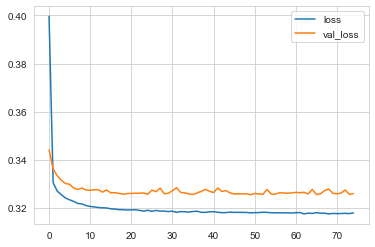

In [61]:
model_2_losses=pd.DataFrame(model_2.history.history)
model_2_losses.plot()

### Stopped after  75 epochs

In [62]:
#Passing X_test into model
predictions2 = model_2.predict_classes(X_test)

In [63]:
from sklearn.metrics import classification_report, confusion_matrix

In [64]:
print(classification_report(y_test,predictions2))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      5858
           1       0.70      0.13      0.22       853

    accuracy                           0.88      6711
   macro avg       0.79      0.56      0.58      6711
weighted avg       0.86      0.88      0.85      6711



In [65]:
print(confusion_matrix(y_test,predictions2))

[[5809   49]
 [ 739  114]]


### This model which utilized early stopping after 75 epochs improved slightly upon the previous model by reducing the validation loss a bit

#### This model correctly identified 5809 non-upgrading fans out of the total 5858 fans (True +) and <br> 
#### Correctly identified 114  of the upgraders as upgrading fans (True -) for an accuracy of 88%, but <br>
#### The model incorrectly classified 739 fans that upgraded as non-upgraders (False +) and incorrectly classified 49 non-upgraded fans as Upgraders (False -)

### 3rd thing we could do is to add in drop out layers that essentially turn off a % of neurons randomly
#### Creating new model drop out layers example,
#### The rate used below 0.5 , means turn off 1/2 neurons in each step 

In [66]:
from tensorflow.keras.layers import Dropout

In [67]:
model_3 = Sequential()
model_3.add(Dense(units=11,activation='relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(units=5,activation='relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(units=1,activation='sigmoid'))
model_3.compile(loss='binary_crossentropy', optimizer='adam')

In [68]:
model_3.fit(x=X_train, 
          y=y_train, 
          epochs=200,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/200
630/630 [==============================] - 0s 677us/step - loss: 0.5033 - val_loss: 0.3757
Epoch 2/200
630/630 [==============================] - 0s 581us/step - loss: 0.4040 - val_loss: 0.3522
Epoch 3/200
630/630 [==============================] - 0s 584us/step - loss: 0.3785 - val_loss: 0.3530
Epoch 4/200
630/630 [==============================] - 0s 585us/step - loss: 0.3661 - val_loss: 0.3507
Epoch 5/200
630/630 [==============================] - 0s 583us/step - loss: 0.3604 - val_loss: 0.3504
Epoch 6/200
630/630 [==============================] - 0s 579us/step - loss: 0.3602 - val_loss: 0.3521
Epoch 7/200
630/630 [==============================] - 0s 611us/step - loss: 0.3603 - val_loss: 0.3537
Epoch 8/200
630/630 [==============================] - 0s 606us/step - loss: 0.3574 - val_loss: 0.3538
Epoch 9/200
630/630 [==============================] - 0s 585us/step - loss: 0.3568 - val_loss: 0.3546
Epoch 10/200
630/630 [==============================] - 0s 583us/step - l

Epoch 80/200
630/630 [==============================] - 0s 621us/step - loss: 0.3458 - val_loss: 0.3410
Epoch 81/200
630/630 [==============================] - 0s 584us/step - loss: 0.3463 - val_loss: 0.3416
Epoch 82/200
630/630 [==============================] - 0s 602us/step - loss: 0.3436 - val_loss: 0.3421
Epoch 83/200
630/630 [==============================] - 0s 591us/step - loss: 0.3450 - val_loss: 0.3414
Epoch 84/200
630/630 [==============================] - 0s 603us/step - loss: 0.3445 - val_loss: 0.3421
Epoch 85/200
630/630 [==============================] - 0s 576us/step - loss: 0.3433 - val_loss: 0.3427
Epoch 86/200
630/630 [==============================] - 0s 660us/step - loss: 0.3460 - val_loss: 0.3426
Epoch 87/200
630/630 [==============================] - 0s 598us/step - loss: 0.3453 - val_loss: 0.3409
Epoch 88/200
630/630 [==============================] - 0s 572us/step - loss: 0.3453 - val_loss: 0.3416
Epoch 89/200
630/630 [==============================] - 0s 590us

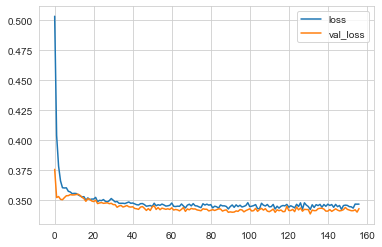

In [69]:
model_3_losses=pd.DataFrame(model_3.history.history)
model_3_losses.plot()

In [70]:
#Passing X_test into model
predictions3 = model_3.predict_classes(X_test)

In [71]:
from sklearn.metrics import classification_report, confusion_matrix

In [72]:
print(classification_report(y_test,predictions3))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      5858
           1       0.00      0.00      0.00       853

    accuracy                           0.87      6711
   macro avg       0.44      0.50      0.47      6711
weighted avg       0.76      0.87      0.81      6711



In [73]:
print(confusion_matrix(y_test,predictions3))

[[5858    0]
 [ 853    0]]


### This model performed worst then the previous 2 even with using the Early Stop and Drop out layers

#### Although the loss plot has improved the model does not do a good job at predicting the target class =1 which is pass one fans that upgrade , the model determined that the 853 upgraders were not upgrade customers (False +) . The model did correctly identify all 5858 non-upgrade fans with a recall of 1.0.  

### Summary

### Lack of demographic and other features available in the data inhibited the ability to distinguish the class upgrade_fan all models do a decent job of classifying who doesn't upgrade but horribly predicts who will upgrade